In [ ]:
# PyTorch + TorchVision (CUDA 12.1 builds that Colab expects)
!pip install -q torch==2.3.0+cu121 torchvision==0.18.0+cu121 torchaudio==2.3.0 --extra-index-url https://download.pytorch.org/whl/cu121

# Make sure NumPy is new enough for TorchVision’s image pipeline
!pip install -q --upgrade "numpy>=2.2.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt, random
from torchvision import transforms
from torchvision.datasets import GTSRB
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

print("Torch     :", torch.__version__)
print("CUDA OK?  :", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
device


Torch     : 2.3.0+cu121
CUDA OK?  : False


'cpu'

In [ ]:
root = "/content/gtsrb"

# Simple, robust transforms (PIL→Tensor without NumPy hand-off)
train_tf = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomAffine(15, translate=(0.15,0.15)),
    transforms.ColorJitter(0.3,0.3,0.3),
    transforms.RandomHorizontalFlip(0.2),
    transforms.PILToTensor(),                       # → uint8
    transforms.ConvertImageDtype(torch.float32),    # → float32 [0,1]
])
val_tf = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

full_train = GTSRB(root=root, split="train", download=True, transform=train_tf)
test_ds    = GTSRB(root=root, split="test",  download=True, transform=val_tf)

# 90/10 split for train/val
train_size = int(0.9 * len(full_train))
val_size   = len(full_train) - train_size
train_ds, val_ds = random_split(full_train, [train_size, val_size],
                                generator=torch.Generator().manual_seed(42))
# ensure val uses val transforms
val_ds.dataset.transform = val_tf

BATCH = 128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)


100%|██████████| 187490228/187490228 [00:05<00:00, 34241445.06it/s]


Extracting /content/gtsrb/gtsrb/GTSRB-Training_fixed.zip to /content/gtsrb/gtsrb


100%|██████████| 88978620/88978620 [00:03<00:00, 29005531.35it/s]


Extracting /content/gtsrb/gtsrb/GTSRB_Final_Test_Images.zip to /content/gtsrb/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 361954.73it/s]


Extracting /content/gtsrb/gtsrb/GTSRB_Final_Test_GT.zip to /content/gtsrb/gtsrb


(188, 21, 99)

In [ ]:
class TinyCNN(nn.Module):
    def __init__(self, n_classes=43):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                # 24x24
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                # 12x12
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                # 6x6
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*6*6, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, n_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

model = TinyCNN().to(device)
sum(p.numel() for p in model.parameters()), device


(1284203, 'cpu')

In [ ]:
EPOCHS = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for ep in range(1, EPOCHS+1):
    # Train
    model.train()
    loss_sum = correct = total = 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct  += (out.argmax(1) == y).sum().item()
        total    += y.size(0)
    tr_loss = loss_sum/total; tr_acc = 100*correct/total

    # Val
    model.eval()
    v_loss = v_corr = v_tot = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            v_loss += criterion(out, y).item() * x.size(0)
            v_corr += (out.argmax(1) == y).sum().item()
            v_tot  += y.size(0)
    val_loss = v_loss/v_tot; val_acc = 100*v_corr/v_tot
    print(f"Epoch {ep:02d}: Train {tr_acc:5.1f}% | Val {val_acc:5.1f}% (loss {val_loss:.3f})")


Epoch 01: Train  29.1% | Val  68.9% (loss 1.037)
Epoch 02: Train  75.3% | Val  92.3% (loss 0.296)
Epoch 03: Train  88.6% | Val  96.4% (loss 0.159)
Epoch 04: Train  93.4% | Val  97.3% (loss 0.103)
Epoch 05: Train  95.5% | Val  98.4% (loss 0.060)


In [ ]:
model.eval()
t_corr = t_tot = 0
with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        t_corr += (out.argmax(1) == y).sum().item()
        t_tot  += y.size(0)
test_acc = 100*t_corr/t_tot
print(f"✅ Test accuracy: {test_acc:.2f}%")


✅ Test accuracy: 90.25%


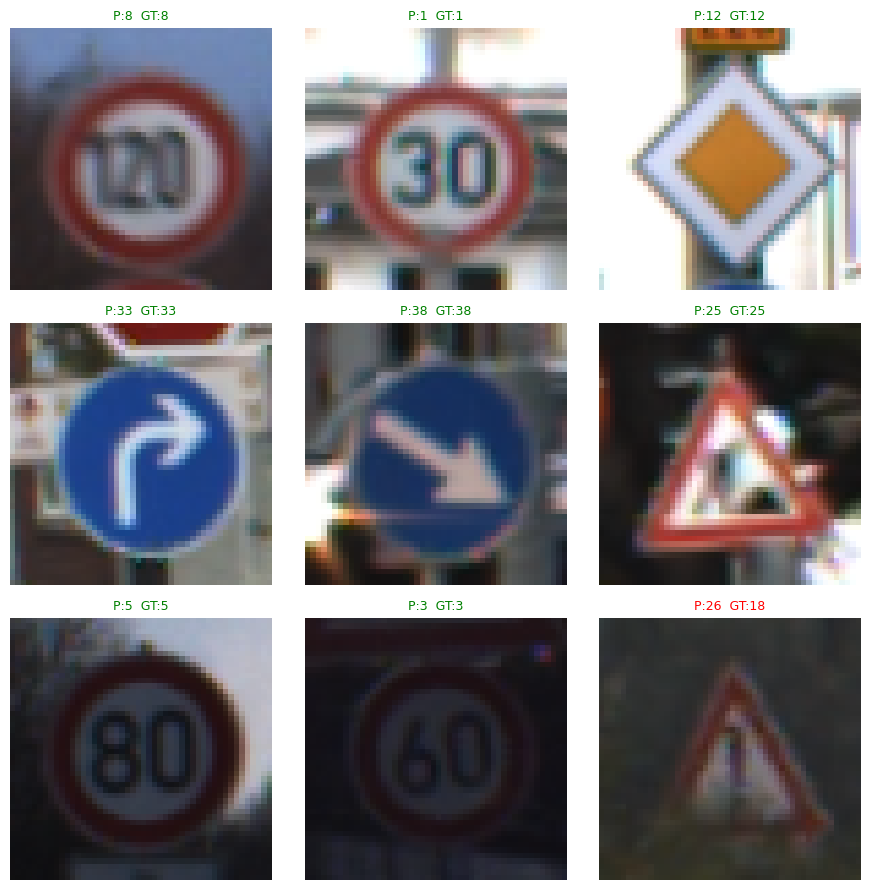

Saved: /content/tinycnn_fp32.pt and /content/sample_predictions_grid.png


In [ ]:
# Save weights
torch.save(model.state_dict(), "/content/tinycnn_fp32.pt")

# Make a 3x3 grid of predictions (green = correct, red = wrong)
model.eval()
idxs = random.sample(range(len(test_ds)), 9)
fig, axes = plt.subplots(3,3, figsize=(9,9))
for ax, idx in zip(axes.flatten(), idxs):
    img, gt = test_ds[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
    ax.imshow(img.permute(1,2,0).cpu())
    ax.set_title(f"P:{pred}  GT:{gt}", color=("green" if pred==gt else "red"), fontsize=9)
    ax.axis("off")
plt.tight_layout(); plt.show()
fig.savefig("/content/sample_predictions_grid.png", dpi=300)
print("Saved: /content/tinycnn_fp32.pt and /content/sample_predictions_grid.png")


In [ ]:
from google.colab import files
files.download("/content/tinycnn_fp32.pt")
files.download("/content/sample_predictions_grid.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GT: class_19 | Pred: class_19  (conf=0.3217)


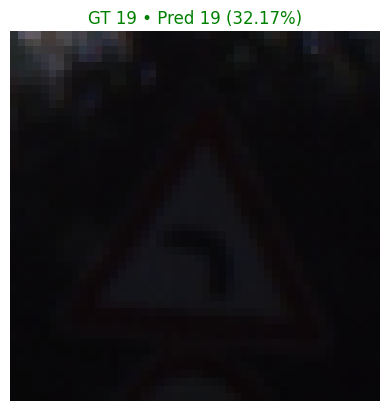

In [13]:
import torch, torch.nn as nn
from torchvision import transforms
from torchvision.datasets import GTSRB
import numpy as np, matplotlib.pyplot as plt, random
from pathlib import Path
from PIL import Image

# --- TinyCNN ---
class TinyCNN(nn.Module):
    def __init__(self, n_classes=43):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(128*6*6,256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256,43)
        )
    def forward(self,x): return self.classifier(self.features(x))

WEIGHTS = "/content/tinycnn_fp32.pt"
assert Path(WEIGHTS).exists(), "Weights not found. Adjust path."

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyCNN().to(device)
model.load_state_dict(torch.load(WEIGHTS, map_location=device))
model.eval()

val_tf = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

root = "/content/gtsrb"  # same root you used before
test_ds = GTSRB(root=root, split="test", download=True, transform=val_tf)

# choose a random test image
idx = random.randrange(len(test_ds))
img_t, gt = test_ds[idx]         # tensor + numeric ground truth
img = Image.fromarray((img_t.permute(1,2,0).numpy()*255).astype("uint8"))

with torch.no_grad():
    probs = model(img_t.unsqueeze(0).to(device)).softmax(1).cpu().numpy()[0]
pred = int(np.argmax(probs))
conf = float(probs[pred])

print(f"GT: class_{gt} | Pred: class_{pred}  (conf={conf:.4f})")
plt.imshow(img); plt.title(f"GT {gt} • Pred {pred} ({conf:.2%})", color=("green" if pred==gt else "red"))
plt.axis("off"); plt.show()


GT : Stop
Pred: Stop  (conf=0.9999)

Top-5:
Stop                                 0.9999
Speed limit (60km/h)                 0.0000
No entry                             0.0000
Speed limit (120km/h)                0.0000
Road work                            0.0000


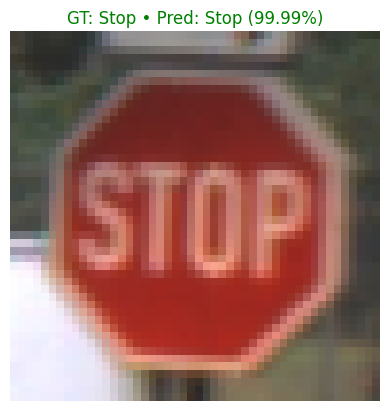

In [19]:
import torch, torch.nn as nn, numpy as np, random, matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import GTSRB
from torchvision.transforms.functional import to_pil_image
from pathlib import Path

# ---- GTSRB class names (index 0..42) ----
CLASS_NAMES = [
    "Speed limit (20km/h)", "Speed limit (30km/h)", "Speed limit (50km/h)",
    "Speed limit (60km/h)", "Speed limit (70km/h)", "Speed limit (80km/h)",
    "End of speed limit (80km/h)", "Speed limit (100km/h)", "Speed limit (120km/h)",
    "No passing", "No passing for vehicles >3.5t", "Right-of-way at next intersection",
    "Priority road", "Yield", "Stop", "No vehicles", "Vehicles >3.5t prohibited",
    "No entry", "General caution", "Dangerous curve left", "Dangerous curve right",
    "Double curve", "Bumpy road", "Slippery road", "Road narrows on right",
    "Road work", "Traffic signals", "Pedestrians", "Children crossing",
    "Bicycles crossing", "Beware of ice/snow", "Wild animals crossing",
    "End of all speed and passing limits", "Turn right ahead", "Turn left ahead",
    "Ahead only", "Go straight or right", "Go straight or left", "Keep right",
    "Keep left", "Roundabout mandatory", "End of no passing",
    "End of no passing for vehicles >3.5t"
]
assert len(CLASS_NAMES) == 43

# ---- TinyCNN (must match your trained model) ----
class TinyCNN(nn.Module):
    def __init__(self, n_classes=43):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(128*6*6,256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256,n_classes)
        )
    def forward(self,x): return self.classifier(self.features(x))

# ---- load weights ----
WEIGHTS = "/content/tinycnn_fp32.pt"    # change if your path differs
assert Path(WEIGHTS).exists(), f"Weights not found at {WEIGHTS}"
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyCNN().to(device)
model.load_state_dict(torch.load(WEIGHTS, map_location=device))
model.eval()

# ---- dataset/transform ----
val_tf = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])
root = "/content/gtsrb"
test_ds = GTSRB(root=root, split="test", download=True, transform=val_tf)

# ---- choose a random test sample, predict, and show names ----
idx = random.randrange(len(test_ds))
img_t, gt = test_ds[idx]               # tensor in [0,1]
with torch.no_grad():
    probs = model(img_t.unsqueeze(0).to(device)).softmax(1).cpu().numpy()[0]

pred_id = int(np.argmax(probs))
pred_name = CLASS_NAMES[pred_id]
gt_name   = CLASS_NAMES[gt]

print(f"GT : {gt_name}")
print(f"Pred: {pred_name}  (conf={probs[pred_id]:.4f})")

# top-5 table
top5_idx = np.argsort(probs)[::-1][:5]
print("\nTop-5:")
for i in top5_idx:
    print(f"{CLASS_NAMES[int(i)]:35s}  {probs[i]:.4f}")

# plot with readable title
img_pil = to_pil_image(img_t)          # convert tensor -> PIL for display
title = f"GT: {gt_name} • Pred: {pred_name} ({probs[pred_id]:.2%})"
plt.imshow(img_pil)
plt.title(title, color=("green" if pred_id==gt else "red"))
plt.axis("off")
plt.show()


In [20]:
# Text-to-speech in Colab
!pip -q install gTTS


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.6 MB/s eta 0:00:00


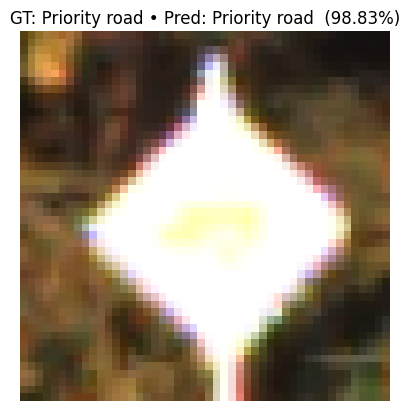

Speaking: Priority road.


In [26]:
import torch, torch.nn as nn, numpy as np, random, re, time
from torchvision import transforms
from torchvision.datasets import GTSRB
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from gtts import gTTS
from IPython.display import Audio, display

# ---------- GTSRB class names (43) ----------
CLASS_NAMES = [
    "Speed limit (20km/h)","Speed limit (30km/h)","Speed limit (50km/h)",
    "Speed limit (60km/h)","Speed limit (70km/h)","Speed limit (80km/h)",
    "End of speed limit (80km/h)","Speed limit (100km/h)","Speed limit (120km/h)",
    "No passing","No passing for vehicles >3.5t","Right-of-way at next intersection",
    "Priority road","Yield","Stop","No vehicles","Vehicles >3.5t prohibited",
    "No entry","General caution","Dangerous curve left","Dangerous curve right",
    "Double curve","Bumpy road","Slippery road","Road narrows on right",
    "Road work","Traffic signals","Pedestrians","Children crossing",
    "Bicycles crossing","Beware of ice/snow","Wild animals crossing",
    "End of all speed and passing limits","Turn right ahead","Turn left ahead",
    "Ahead only","Go straight or right","Go straight or left","Keep right",
    "Keep left","Roundabout mandatory","End of no passing",
    "End of no passing for vehicles >3.5t"
]

# ---------- TinyCNN (same as you trained) ----------
class TinyCNN(nn.Module):
    def __init__(self, n_classes=43):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(128*6*6,256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, n_classes)
        )
    def forward(self,x): return self.classifier(self.features(x))

# ---------- Load model & test set (safe even after restart) ----------
WEIGHTS = "/content/tinycnn_fp32.pt"     # change if your file is elsewhere
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TinyCNN().to(device)
model.load_state_dict(torch.load(WEIGHTS, map_location=device))
model.eval()

val_tf = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])
root = "/content/gtsrb"
test_ds = GTSRB(root=root, split="test", download=True, transform=val_tf)

# ---------- Turn class name into a short spoken phrase ----------
def make_phrase(class_name: str) -> str:
    # Speed limits → "Speed limit 50 kilometers per hour"
    m = re.match(r"Speed limit \((\d+)km/h\)", class_name)
    if m: return f"Speed limit {m.group(1)} kilometers per hour."
    # Common signs
    rules = {
        "Stop": "Stop sign.",
        "Yield": "Yield ahead.",
        "No entry": "Do not enter.",
        "No vehicles": "No vehicles allowed.",
        "Right-of-way at next intersection": "Right of way at the next intersection.",
        "Priority road": "Priority road.",
        "Pedestrians": "Pedestrian crossing ahead.",
        "Children crossing": "Children crossing ahead.",
        "Bicycles crossing": "Bicycle crossing ahead.",
        "Traffic signals": "Traffic signals ahead.",
        "Road work": "Road work ahead.",
        "Roundabout mandatory": "Roundabout ahead.",
        "Keep right": "Keep right.",
        "Keep left": "Keep left.",
        "Turn right ahead": "Turn right ahead.",
        "Turn left ahead": "Turn left ahead.",
        "Ahead only": "Ahead only.",
        "General caution": "Caution.",
    }
    for k, v in rules.items():
        if class_name == k:
            return v
    # Default
    return f"{class_name}."

# ---------- Speak helper ----------
def speak(text: str, path: str = None):
    if path is None:
        path = f"/content/tts_{int(time.time()*1000)}.mp3"
    gTTS(text=text, lang="en").save(path)
    audio = Audio(path, autoplay=True)
    display(audio)
    return path

# ---------- Predict + speak ----------
def predict_and_say(pil_img: Image.Image = None, index: int = None):
    # Source image: random test sample OR provided PIL image
    if pil_img is None:
        if index is None:
            index = random.randrange(len(test_ds))
        img_t, gt = test_ds[index]
        img_pil = Image.fromarray((img_t.permute(1,2,0).numpy() * 255).astype("uint8"))
    else:
        img_pil = pil_img.convert("RGB")
        img_t = val_tf(img_pil)
        gt = None

    with torch.no_grad():
        probs = model(img_t.unsqueeze(0).to(device)).softmax(1).cpu().numpy()[0]
    pred_id = int(np.argmax(probs))
    pred_name = CLASS_NAMES[pred_id]
    phrase = make_phrase(pred_name)

    # Visual result
    title = f"Pred: {pred_name}  ({probs[pred_id]:.2%})"
    if gt is not None:
        title = f"GT: {CLASS_NAMES[gt]} • " + title
    plt.imshow(img_pil); plt.title(title); plt.axis("off"); plt.show()

    print("Speaking:", phrase)
    speak(phrase)

# ----------- EXAMPLE USAGE -----------
# A) random test image:
predict_and_say()

# B) OR upload an image from your computer:
# from google.colab import files
# up = files.upload()
# fname = next(iter(up.keys()))
# predict_and_say(Image.open(fname))
